# Predicting World Cup 2014

Let's build a model that uses score differentials from initial stages of World Cup 2014 as data. Additionally, we will fit the model on square-root scale as extra goals don’t provide as much information when the game is not close.

## Data

Our data contains the results of 62 matches, collected from the start of the World Cup upto 13 July 2014. Since our data is small, we will use the Soccer Power Index (from back then) as prior information about each team.

## Model

If team $i$ and team $j$ are playing and score $y_i$ and $y_j$ goals, then the data point for this game is $y_{ij} = sign(y_i - y_j)*\sqrt{|y_i-y_j|}$, and the data model is:

$$y_{ij} \sim Normal(a_i-a_j, \sigma{y})$$

where $a_i$ and $a_j$ are the ability parameters for the two teams and $\sigma{y}$ is a scale parameter estimated from the data.

We will use a $t$ distribution as our data contains some outliers (eg Germany - Brazil match):

$$y_{ij} \sim t_{df}(a_i-a_j, \sigma{y})$$

setting the degrees of freedom to df=7 which has been occasionally recommended as a robust alternative to the normal.

Given our prior information based on the Soccer Power Index (SPI), the model for each team ability is (relative to others):

$$a_i \sim Normal(b * \text{SPI}_i, \sigma{a})$$

where $b$, $\sigma{y}$, $\sigma{a}$ are model parameters.

In [1]:
library(tidyverse)
library(ggthemes) # visualization
library(rstan)
library(bayesplot)
library(arm)
library(tidybayes)

theme_update(plot.title = element_text(hjust = 0.5))

teams <- as.vector (unlist (read.table ("data/power_index.txt", header=FALSE)))
nteams <- length(teams)
prior_score <- rev(1:nteams)
prior_score <- (prior_score - mean(prior_score))/(2*sd(prior_score))

data2012 <- read.table ("data/world_cup.txt", header=FALSE)
ngames <- nrow (data2012)

team1 <- match (as.vector(data2012[[1]]), teams)
score1 <- as.vector(data2012[[2]])
team2 <- match (as.vector(data2012[[3]]), teams)
score2 <- as.vector(data2012[[4]])

df <- 7

data <- c("nteams","ngames","team1","score1","team2","score2","prior_score","df")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: StanHeaders
rstan (Version 2.16.2, packaged: 2017-07-03 09:24:58 UTC, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

Attaching package: ‘rstan’

The following object is masked from ‘package:tidyr’:

    extract

This is bayesplot version 1.4.0
- Plotting theme set to bayesplot::theme_default()
- Online documentation at mc-stan.org/bayesplot
Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked fr

In [2]:
fit <- stan("models/worldcup_model.stan", data=data, chains=4, iter=1000)

In file included from file1388366b580cc.cpp:8:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core.hpp:12:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/var.hpp:7:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/math/tools/config.hpp:13:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/config.hpp:39:
/usr/local/lib/R/3.4/site-library/BH/include/boost/config/compiler/clang.hpp:200:11: warning: 'BOOST_NO_CXX11_RVALUE_REFERENCES' macro r

In [3]:
fit

Inference for Stan model: worldcup_model.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
b           0.92    0.00 0.18   0.56   0.80   0.93   1.05   1.27  2000 1.00
sigma_a     0.27    0.01 0.14   0.02   0.15   0.26   0.37   0.55   486 1.00
sigma_y     0.85    0.00 0.11   0.65   0.77   0.84   0.92   1.07  2000 1.00
eta_a[1]   -0.16    0.02 0.86  -1.82  -0.73  -0.15   0.42   1.48  2000 1.00
eta_a[2]    0.18    0.02 0.81  -1.46  -0.35   0.21   0.70   1.74  2000 1.00
eta_a[3]    0.62    0.02 0.90  -1.19   0.04   0.62   1.25   2.34  2000 1.00
eta_a[4]   -0.62    0.02 0.97  -2.47  -1.25  -0.64   0.02   1.31  2000 1.00
eta_a[5]    0.00    0.02 0.88  -1.71  -0.59  -0.02   0.59   1.74  2000 1.00
eta_a[6]    0.21    0.02 0.89  -1.52  -0.35   0.20   0.79   2.02  2000 1.00
eta_a[7]    0.58    0.02 0.88  -1.25   0.02   0.60   1.19   2.28  2000 1.00
eta_a[

The etas are the team-level residuals and the a's are team abilities. The group-level error sd sigma_a is estimated at 0.26 which indicates that our final estimates of team abilities are dominated by the power index. This is due to factors: initial ranking is accurate and there is just not enough data.

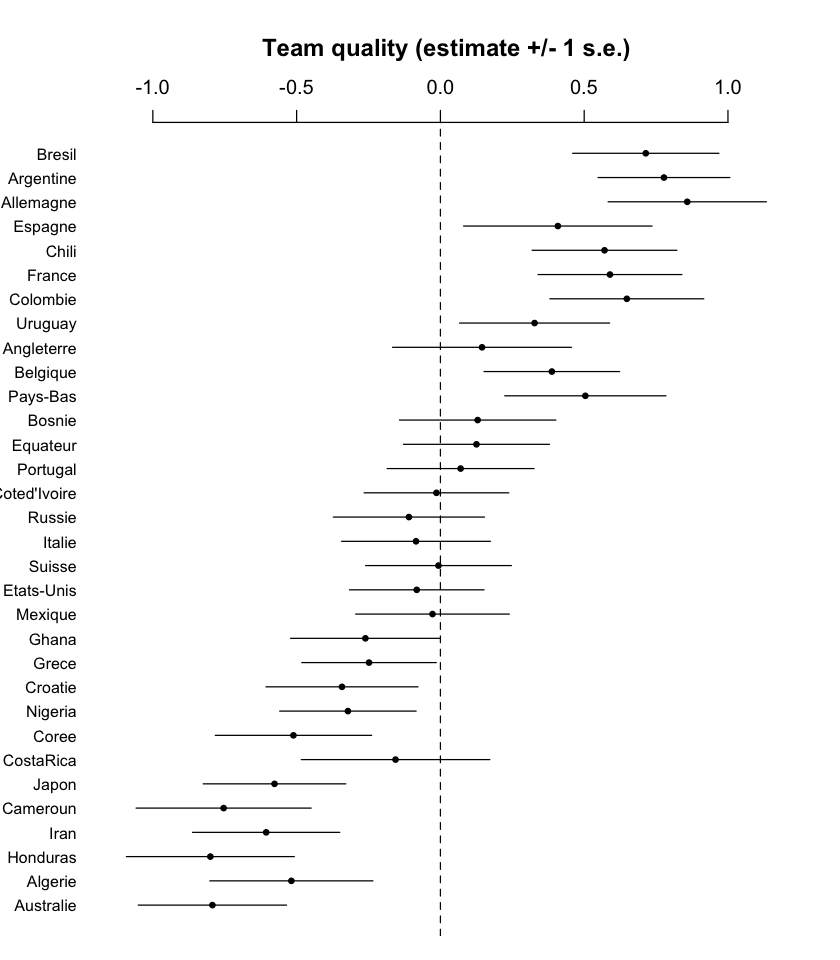

In [4]:
options(repr.plot.width=7, repr.plot.height=8)

colVars <- function(a) {n <- dim(a)[[1]]; c <- dim(a)[[2]]; return(.colMeans(((a - matrix(.colMeans(a, n, c), nrow = n, ncol = c, byrow = TRUE)) ^ 2), n, c) * n / (n - 1))}

plot_team_quality <- function(fit) {

    sims <- rstan::extract(fit)
    a_sims <- sims$a
    a_hat <- colMeans(a_sims)
    a_se <- sqrt(colVars(a_sims))
    coefplot(
        rev(a_hat), 
        rev(a_se), 
        CI=1,
        varnames=rev(teams), 
        main="Team quality (estimate +/- 1 s.e.)\n"
    )
}

plot_team_quality(fit)

In [5]:
fit_noprior <- stan("models/worldcup_noprior_model.stan", data=data, chains=4, iter=1000)

In file included from file13883bc08083.cpp:8:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core.hpp:12:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/var.hpp:7:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/math/tools/config.hpp:13:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/config.hpp:39:
/usr/local/lib/R/3.4/site-library/BH/include/boost/config/compiler/clang.hpp:200:11: warning: 'BOOST_NO_CXX11_RVALUE_REFERENCES' macro re

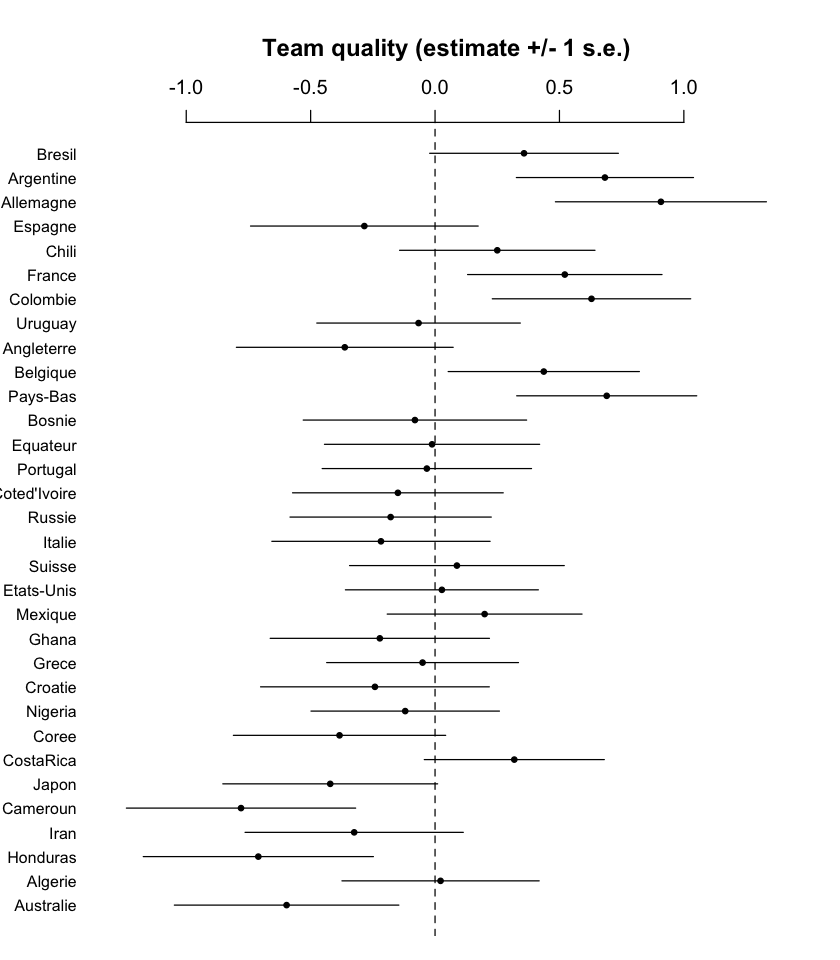

In [6]:
plot_team_quality(fit_noprior)

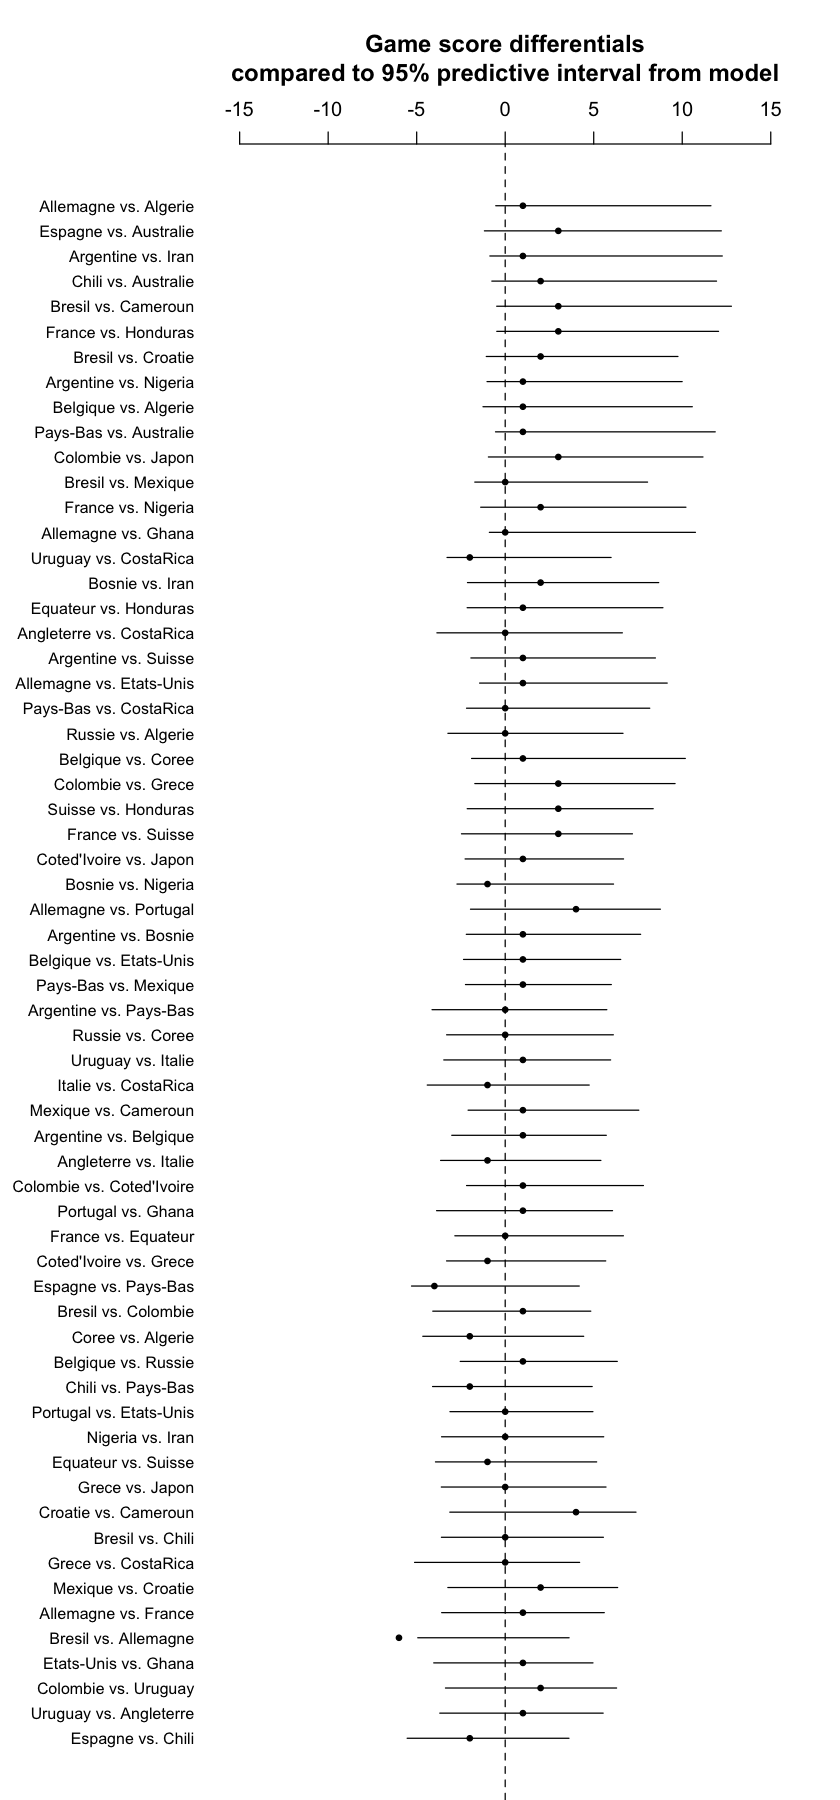

In [7]:
signed_square <- function (a) {sign(a)*a^2}

sims <- rstan::extract (fit)
a_sims <- sims$a
sigma_y_sims <- sims$sigma_y
nsims <- length(sigma_y_sims)
random_outcome <- array(NA, c(nsims,ngames))
for (s in 1:nsims){
  random_outcome_on_sqrt_scale <- (a_sims[s,team1] - a_sims[s,team2]) + rt(ngames,df)*sigma_y_sims[s]
  random_outcome[s,] <- signed_square(random_outcome_on_sqrt_scale)
}
sim_quantiles <- array(NA,c(ngames,2))
for (i in 1:ngames){
  sim_quantiles[i,] <- quantile(random_outcome[,i], c(.025,.975))
}

# Do it again, rounding the continuous predictions:

for (i in 1:ngames){
  sim_quantiles[i,] <- quantile(round(random_outcome[,i]), c(.025,.975))
}

# Reorder the games in order of predicted score differential
new_order <- order(prior_score[team1] - prior_score[team2])

for (i in 1:ngames){
  sim_quantiles[i,] <- quantile(random_outcome[,i], c(.025,.975))
}

# Flip so expected outcomes are always positive
flip <- ifelse (prior_score[team1] < prior_score[team2], -1, 1)
new_order <- order((prior_score[team1] - prior_score[team2])*flip)
flip <- flip[new_order]
options(repr.plot.width=7, repr.plot.height=15)

coefplot ((score1 - score2)[new_order]*flip, sds=rep(0, ngames),
          lower.conf.bounds=sim_quantiles[new_order,1]*flip, upper.conf.bounds=sim_quantiles[new_order,2]*flip, 
          varnames=ifelse(flip==1, paste(teams[team1[new_order]], "vs.", teams[team2[new_order]]),
                          paste(teams[team2[new_order]], "vs.", teams[team1[new_order]])),
          main="Game score differentials\ncompared to 95% predictive interval from model\n",
          mar=c(0,7,6,2), xlim=c(-15,15))